# SunCET dynamic range testing and analysis
## This version is on Google Drive

*Usage Note:* I have created a link to this file in my perosonal GoogleDrive and it opens and runs fine in Annaconda Jupyter Notebook on my local machine [ARJ]


*Usage Note2:* Runs in Google Colaboratory:  http://colab.research.google.com The easiest way I have found to do this is to open my GoogleDrive and right-click on the notebook and select "open with google colaboratory". 
To run a local server via colaboratory Safari does not work, but Firefox does  

*Usage Note3:* Setup instructions to run local kernel: https://research.google.com/colaboratory/local-runtimes.html
I want to start using the local kernel as at times the Google runtime is timing out frustratingly often, however it is not finding my local python modlues yet. --- I think this was because my local Annaconda does not set the PYTHONHOME environment variable (I set PYTHONHOME and PYTHONPATH manually and it works. -I think that my problems are stemming from having 2 versions of python installed, one in X Code, and one in annaconda, I am still working on getting the local runtime to work reliably [ARJ].

I have added a section to read the .hex files from the CCAP camera [ARJ].

I have added an offset for the Airy Disk calculation: xcen, ycen that is the center in pixel# [ARJ].

# Table of Contents

* [Setup](#setup)
* [Calculate Airy Disk](#airy)
    * [Selective Readout](#selective)
* [Lab Setup](#lab)
* [Read data files](#read_data)



## Setup <a class="anchor" id="setup"></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.constants as sic
from scipy.special import jv
import glob
import sys,getopt
import os


## Calculate Airy Disk to model expected response <a class="anchor" id="airy"></a>

In [ ]:
def do_airy(l0, a, angle):
# Calculate the Airy function
# https://en.wikipedia.org/wiki/Airy_disk
    k = 2.0 *np.pi/l0    
    xx = k*a*np.sin(angle)
    top = 2.0 *jv(1,xx)
    bot = xx
    airy =(top/bot)**2
    return airy

In [ ]:
def do_sinc2(l0, a, angle):
# Calculate the sync^2 function
    sxx = (2*a/l0)*np.sin(angle)
    sinc1 = np.sin(sxx)/sxx
    sinc2 = sinc1**2
    return sinc2

In [ ]:
plt.rcParams.update({'font.size': 16})

In [ ]:
# What Wavelength
l0 = 632.8e-9 #HeNe
l0 = 543.0e-9 #GreeNe
l0 = 405.0e-9 #Blue laserdiode

#Change colors with wavelength
colm='Reds'
col = 'red'
if l0 <600e-9:
    colm='Greens'
    col='green'
if l0 <480e-9: 
    colm='Blues'
    col='blue'
a = 12.5e-6 # radius
k = 2.0 *np.pi/l0

#Baseline plot
theta = np.linspace(1e-6, np.pi/8.0, 5001, dtype=np.float64)
atest = do_airy(l0, a, theta)
s2 = do_sinc2(l0, a, theta)

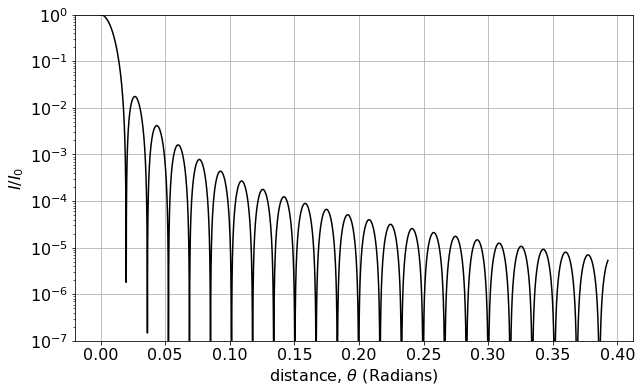

In [ ]:
fig1 = plt.subplots(figsize=(10,6))
plt.plot(theta,atest,'k-')
#plt.plot(theta,s2,'b:')
plt.yscale('log')
plt.ylim(1e-7, 1)
plt.grid()
plt.ylabel(r"$I/I_0}$")
plt.xlabel(r"distance, $\theta$ (Radians)")
#plt.title("Airy / Sinc Intensity")
#plt.text(0.36,0.05, r"sinc($\theta$) ", color='blue')
#plt.text(0.36,0.02, r"Airy($\theta$) ", color='black')
plt.show() 

In [ ]:
dd = 6e-2 # distance to detector in m

# CIS115
dsx = 7e-6 # pixel size
dsy = 7e-6
npixx = 2000
npixy = 1504

xcen = 200  #int(npixx/2)
ycen = 220  #int(npixy/2)

det = np.zeros((npixy,npixx))
detc = [int(ycen),int(xcen)]

xx = np.arange((detc[1])*dsx*-1,(npixx-detc[1])*dsx,dsx )
yy = np.arange((detc[0])*dsy*-1,(npixy-detc[0])*dsy,dsy )

qq = np.arange((detc[1]),(npixx-detc[1]),1 )
x1, y1 = np.meshgrid(xx, yy)
coordinate_grid = np.array([x1, y1])

angles = np.tan(np.sqrt(x1**2 +y1**2))/dd

aa = do_airy(l0, a, angles)
#print(aa.shape)
#print(angles.shape)
#print(detc)

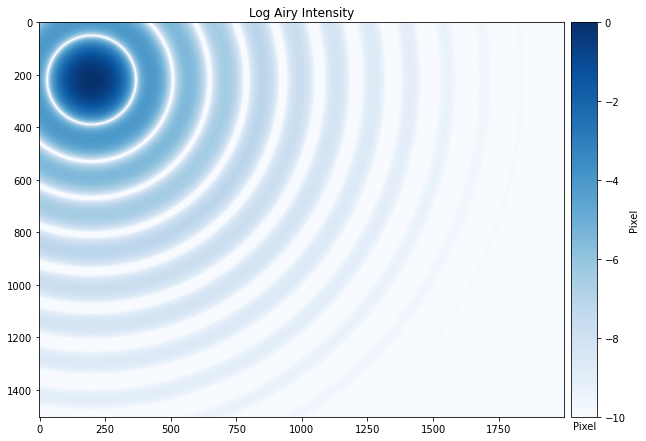

In [ ]:
fig2 = plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(np.log(aa), vmax = 0, vmin = -10, cmap=colm)
plt.title("Log Airy Intensity")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) 
plt.colorbar(im, cax=cax)
plt.ylabel("Pixel")
plt.xlabel("Pixel")
plt.show() 

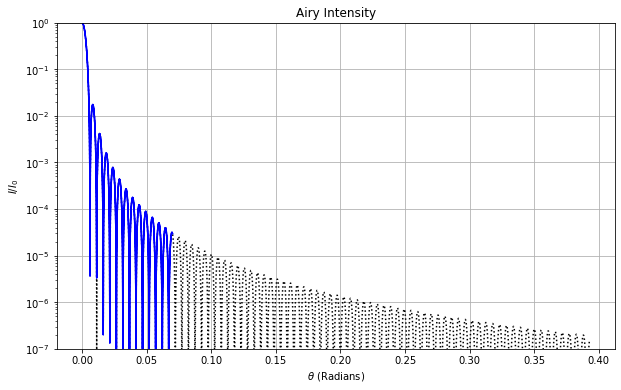

In [ ]:
#check I got the maths right
fig3 =plt.subplots(figsize=(10,6))
plt.plot(theta, atest, 'k:')
plt.plot(angles[detc[0]],aa[detc[0]], color=col)
plt.yscale('log')
plt.ylim(1e-7, 1)
plt.grid()
plt.ylabel(r"$I/I_0}$")
plt.xlabel(r"$\theta$ (Radians)")
plt.title("Airy Intensity")
plt.show()

In [ ]:
focal_ratio = 4.0 # use a lens to demagnify the image
anglesr = focal_ratio*angles

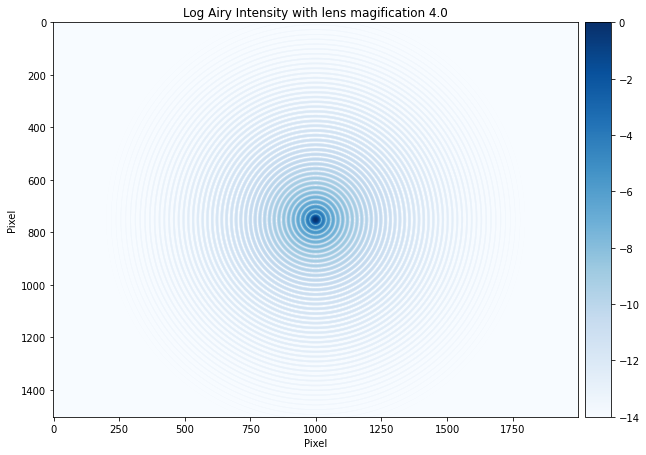

In [ ]:
aar = do_airy(l0, a, anglesr)
ptstr = str("Log Airy Intensity with lens magification {}".format(focal_ratio))
fig4 = plt.subplots(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(np.log(aar), vmax = 0, vmin = -14, cmap=colm)
#plt.imshow(np.log(aar), vmax = 0, vmin = -14, cmap=colm)
plt.title(ptstr)
plt.ylabel("Pixel")
plt.xlabel("Pixel") 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) 
plt.colorbar(im, cax=cax) 
plt.show() 

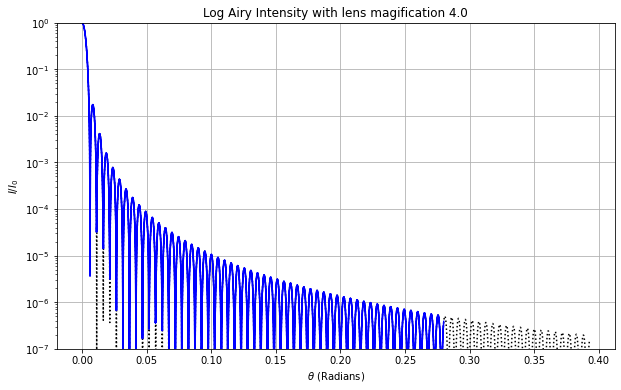

In [ ]:
fig5 = plt.subplots(figsize=(10,6))
plt.plot(theta, atest,'k:')
plt.plot(anglesr[detc[0]],aar[detc[0]], color=col)
plt.yscale('log')
plt.ylim(1e-7, 1)
plt.grid()
plt.ylabel(r"$I/I_0}$")
plt.xlabel(r"$\theta$ (Radians)")
plt.title(ptstr)
plt.show()

In [ ]:
# Calculate diagonal
dmax = np.max([npixx,npixy]) ### This does not do what I want
dmin = np.min([npixx,npixy]) ### as I diectly address the 
dm = dmin/dmax               ### anglesr and aar arrays
adx=[]                       ### so need to test for that still
idx=[]
print(dmax,dmin, dm)
for p in range(dmax):
    py = int(dm*p)
    adx.append(anglesr[py,p])
    idx.append(aar[py,p])

2000 1504 0.752


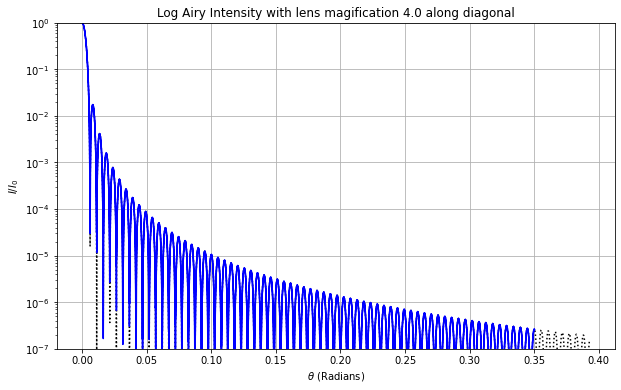

In [ ]:
fig6 =plt.subplots(figsize=(10,6))
plt.plot(theta, atest,'k:')
plt.plot(adx,idx, color=col)
plt.yscale('log')
plt.ylim(1e-7, 1)
plt.grid()
plt.ylabel(r"$I/I_0}$")
plt.xlabel(r"$\theta$ (Radians)")
plt.title(ptstr+ " along diagonal")
plt.show()

We don't need the center in the center of the detector, so we could gain more range, but that makes the ROI calculations v. slightly harder


## Look at selective readout <a class="anchor" id="selective"></a>

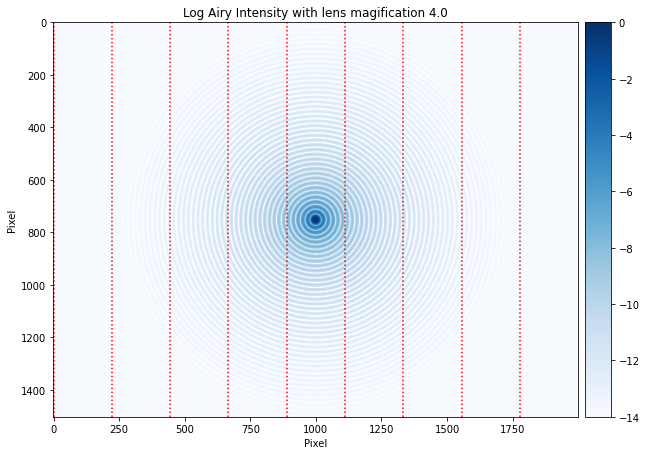

In [ ]:
nzones = 9
vvmax = 0
vvmin =-14
nexp = int(np.floor(nzones/2))
texps = np.linspace(-3,0,nexp, endpoint=False)
zones = np.linspace(0,npixx, nzones, endpoint=False)

exposures = np.ones(nzones)
fig7 = plt.subplots(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(np.log(aar), vmax = 0, vmin = -14, cmap=colm)
plt.title(ptstr)
plt.ylabel("Pixel")
plt.xlabel("Pixel")
#plt.imshow(np.log(aar), vmax = vvmax, vmin = vvmin, cmap=colm)
for z in zones:
    plt.axvline(x=z, color='r', linestyle=':')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) 
plt.colorbar(im, cax=cax) 
plt.show() 

In [ ]:
aarc = np.copy(aar)

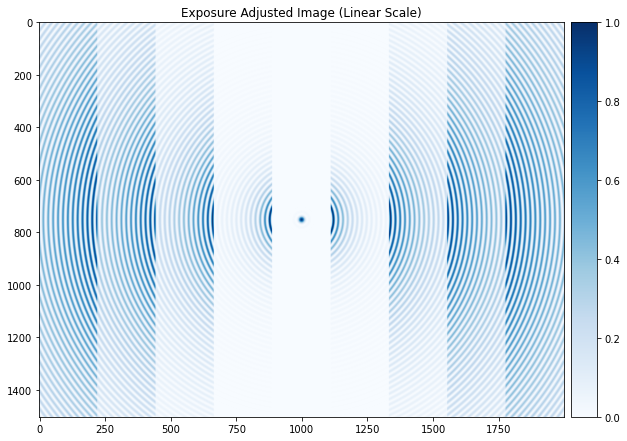

Relative Zone Exposure Times: [9.51103023e+05 3.53891785e+05 8.01758779e+04 3.71351509e+03
 1.00000000e+00 3.71351509e+03 8.01758779e+04 3.53891685e+05
 9.51103023e+05]


In [ ]:
# make 'corrected' image
## Calculate exposures
for cc in range(nzones-1):
    ztmp = int(zones[cc])
    ztmp2 = int(zones[cc+1])
    etmp = np.max(aar[:,ztmp:ztmp2])
    exposures[cc] = 1.0/etmp
    aarc[:,ztmp:ztmp2]= exposures[cc]*aar[:,ztmp:ztmp2]
## do last segment
ztmp = int(zones[cc+1])
etmp = np.max(aar[:,ztmp:])
exposures[cc+1] = 1.0/etmp
aarc[:,ztmp:]= exposures[cc+1]*aar[:,ztmp:]
## Image plot
fig8 = plt.subplots(figsize=(10,10))
ax = plt.gca()
im=ax.imshow((aarc),  cmap=colm)
plt.title("Exposure Adjusted Image (Linear Scale)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) 
plt.colorbar(im, cax=cax)
plt.show()
print('Relative Zone Exposure Times: {}'.format(exposures))

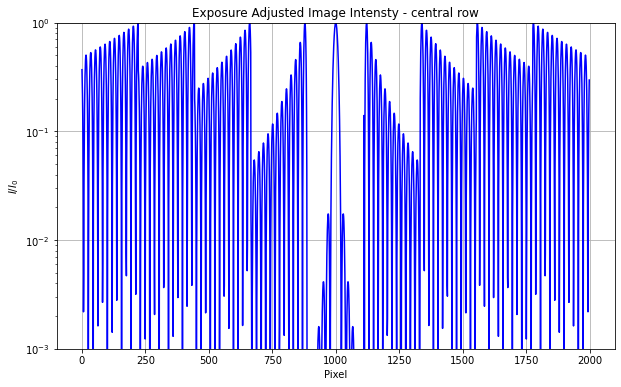

In [ ]:
fig9 =plt.subplots(figsize=(10,6))
plt.plot(aarc[detc[0]], color=col)
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.grid()
plt.ylabel(r"$I/I_0}$")
plt.xlabel("Pixel")
plt.title("Exposure Adjusted Image Intensty - central row")
plt.show()

In [ ]:
# Reconstruct original image
aacr = np.copy(aar)
for cc in range(nzones-1):
    ztmp = int(zones[cc])
    ztmp2 = int(zones[cc+1])
    aacr[:,ztmp:ztmp2]= 1.0/exposures[cc]*aarc[:,ztmp:ztmp2]
# do last segment
ztmp = int(zones[cc+1])
aacr[:,ztmp:]= 1.0/exposures[cc+1]*aarc[:,ztmp:]

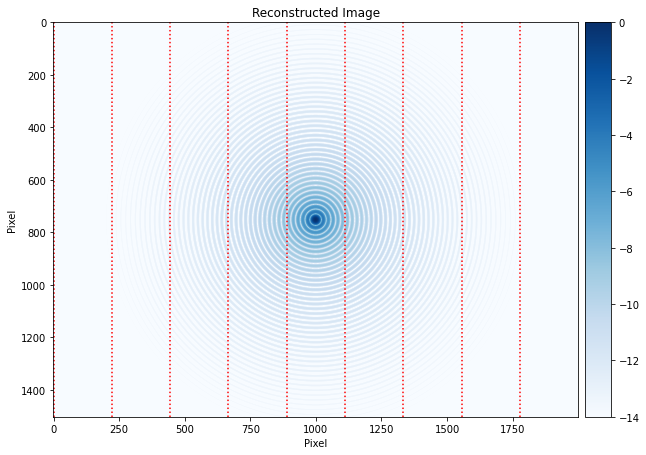

Max Error: 8.470329472543003e-22


In [ ]:
fig10 = plt.subplots(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(np.log(aacr), vmax = 0, vmin = -14, cmap=colm)
plt.title('Reconstructed Image')
plt.ylabel("Pixel")
plt.xlabel("Pixel")
#plt.imshow(np.log(aar), vmax = vvmax, vmin = vvmin, cmap=colm)
for z in zones:
    plt.axvline(x=z, color='r', linestyle=':')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1) 
plt.colorbar(im, cax=cax) 
plt.show() 

test = np.max(aacr-aar)
print("Max Error: {}".format(test))

## Lab Setup <a class="anchor" id="lab"></a>


laser -> [Spatial filter] -> pinhole in X-Y stage -> [lens] -> Detector

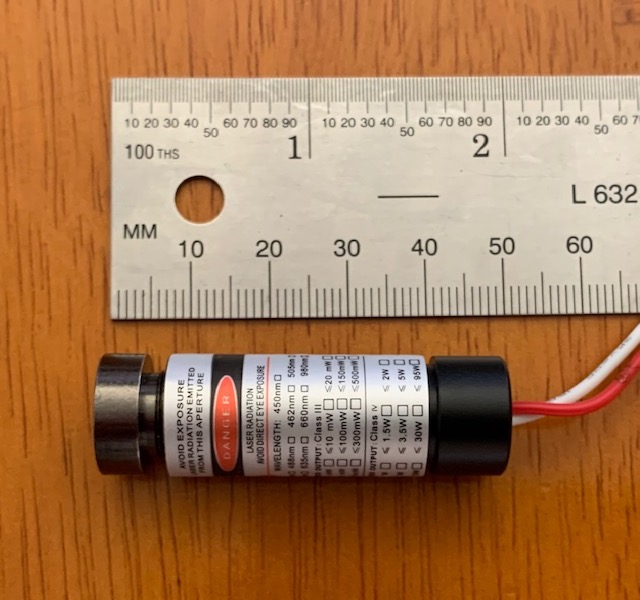

## Read data files <a class="anchor" id="read_data"></a>

In [2]:
#########################
# Common block for CCAP #
#########################
#
# requires import numpy as np
# Defines:
#    Meta dictionary
#    w2i()
#    test_for_meta()
#    read_meta()
#    make_meta()
#    read_hex()
#########################
#
# Build the meta data dictionary [name: (Byte offset, all fields are 2 Bytes long)]
# CCAP Document No. 159822
meta_d = {'META_ID_H': (0)}
meta_d['META_ID_L'] = (2)
meta_d['META_TOTAL_-PKTS_PER_FRM'] = (4)
meta_d['META_SOFT_VER_H'] = (6)
meta_d['META_SOFT_VER_L'] = (8)
meta_d['META_POWER_-CYCLE_CTR'] = (10)
meta_d['META_TIME_H'] = (12)
meta_d['META_TIME_L'] = (14)
meta_d['META_THRM_DET'] = (16)
meta_d['META_THRM_ADC'] = (18)
meta_d['META_THRM_FPGA'] = (20)
meta_d['META_CURR_5V'] = (22)
meta_d['META_VOLT_5V'] = (24)
meta_d['META_ADC_REF'] = (26)
meta_d['META_STATE_TEC'] = (28)
meta_d['META_STATE_FFL'] = (30)
meta_d['META_STATE_SD'] = (32)
meta_d['META_SD_WR_ADDR_H'] = (34)
meta_d['META_SD_WR_ADDR_L'] = (36)
meta_d['META_SERIAL_NUM'] = (38)
meta_d['META_ERROR_CODE'] = (40)
meta_d['PARAM_FRAME_TYPE_CODE'] = (80)
meta_d['PARAM_FRAME_ROWS'] = (82)
meta_d['PARAM_FRAME_COLS'] = (84)
meta_d['PARAM_PRD_FRM_INTG_MS'] = (86)
meta_d['PARAM_PRD_ROW_READ_US'] = (88)
meta_d['PARAM_NUM_ACTIVE_ROWS'] = (90)
meta_d['PARAM_FRST_ACTIVE_ROW'] = (92)
meta_d['PARAM_BIN_ROW'] = (94)
meta_d['PARAM_BIN_COL'] = (96)
meta_d['PARAM_SHIFT_RIGHT'] = (98)

# Function Definitions
# --------------------------------------------------------------#
# Convert 2 Bytes of CCAP data to integer
#
def w2i(b):
    return(int.from_bytes(b, byteorder='little', signed=False))
# --------------------------------------------------------------#
# Test file for meta data
#   Requires:
#      w2i()
#
def test_for_meta(ifn, debug=True):
    block_size = 2
    try:
        with open(ifn,"rb") as f:
            b1 = f.read(block_size)
            b2 = f.read(block_size)
            b3 = f.read(block_size)
        if w2i(b1)==17219 and w2i(b3)==16720:
            MetaDataPresent = True
            if debug: print("test_for_meta: Meta ID: {}, {}".format(hex(w2i(b1)),hex(w2i(b3))))
    except:
        print("test_for_meta: Could not open file {}".format(ifn))
        MetaDataPresent = False
    return(MetaDataPresent)    
# --------------------------------------------------------------#
# Read meta data
#
def read_meta(ifn, debug=True):
    block_size = 2
    meta_size = 512
    m = []
    try:
        with open(ifn,"rb") as f:
            for b in range(meta_size):
                block = f.read(block_size)
                if len(block) != 0:
                    m.append(block)
    except:
        print("read_meta: Could not fopen file {}".format(ifn))
    return(m) 
# --------------------------------------------------------------#
# Fill dictionary with meta data
#   Requires:
#      meta data from read_meta()
#      meta_d: meta data dictionary definition
#
def make_meta(m, meta_d):
    meta_r = dict()
    for k in meta_d:
        b_start = meta_d[k]
        meta_r[k] = w2i(m[b_start])
    return meta_r
# --------------------------------------------------------------#
# Read CCAP image file
# ARJ 9/2/20: use int.from_bytes
# ARJ 9/2/20: updated to check for meta data
# ARJ 9/3/20: added place holder for meta data (m)
# ARJ 9/3/20: now returns the meta data to be read by make_meta()
# ARJ 9/4/20: moved meta data to test_for_meta(), and read_meta()
#   Requires:
#      w2i()
#
def read_hex(ifn, ny, nx, MetaDataPresent = False, debug=False):
    im = np.zeros([ny,nx])
    block_size = 2
    block_offset = -1 # offset of image from start of file    
    block_count = 0
    d = []
    m = []

    if MetaDataPresent:
        if debug: print("read_hex: Meta Data is {}".format(MetaDataPresent))
        block_offset = 250

    try:
        with open(ifn,"rb") as f:
            while True:
                block = f.read(block_size)
                if len(block) == 0:                # breaks loop once no more binary data is read
                    break
                if block_count > block_offset:
                    #d.append(256*block[1]+1*block[0])
                    d.append(int.from_bytes(block, byteorder='little', signed=False))
                else:
                    m.append(block)                # placeholder for the meta data
                block_count = block_count +1
        dd = np.asarray(d)
        if debug: print("read_hex: image shape: {}".format(im.shape))

        for j in range(nx):
            tmp=dd[j*ny:j*ny+(ny)]
            im[:,j]=tmp
        #ovf = np.where(im <0)
        #im[ovf] = im[ovf]+65535
        if debug: print("read_hex: Read file: {}".format(ifn))
        if debug: print("read_hex: nx={} ny={}".format(nx, ny))    
        return(im)
    except:
        print("read_hex: Could not find file: {}".format(ifn))
        return(im )

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config', 'sample_data']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.listdir("/content/drive/My Drive/Colab Notebooks/")

['SunCET_Airy.ipynb',
 'EVE_l0csPlot.ipynb',
 'test.hex',
 'test2.hex',
 'test3.hex',
 'test4.hex']

In [5]:
os.path.isfile("/content/drive/My Drive/Colab Notebooks/test4.hex")

True

In [6]:
ifn = '/content/drive/My Drive/Colab Notebooks/test4.hex'
nxx =   2000 # default
nyy =   1504 # default

# Get the data
MetaDataPresent = test_for_meta(ifn)

print("Meta Data Present: {}".format(MetaDataPresent))
if MetaDataPresent:
    m = read_meta(ifn)
    m_data = make_meta(m, meta_d)
    nxx =  m_data.get('PARAM_FRAME_ROWS', 2000)
    nyy =  m_data.get('PARAM_FRAME_COLS', 1504)
print(nxx, nyy)
im = read_hex(ifn, nyy, nxx, MetaDataPresent, debug=True)

test_for_meta: Meta ID: 0x4343, 0x4150
Meta Data Present: True
1500 1500
read_hex: Meta Data is True
read_hex: image shape: (1500, 1500)
read_hex: Could not find file: /content/drive/My Drive/Colab Notebooks/test4.hex


In [7]:
# example to get the meta data
for k in m_data:
    print(k,":", m_data[k])

META_ID_H : 17219
META_ID_L : 16720
META_TOTAL_-PKTS_PER_FRM : 9001
META_SOFT_VER_H : 308
META_SOFT_VER_L : 15737
META_POWER_-CYCLE_CTR : 1406
META_TIME_H : 263
META_TIME_L : 14113
META_THRM_DET : 1938
META_THRM_ADC : 1948
META_THRM_FPGA : 1539
META_CURR_5V : 1508
META_VOLT_5V : 2032
META_ADC_REF : 2045
META_STATE_TEC : 0
META_STATE_FFL : 0
META_STATE_SD : 0
META_SD_WR_ADDR_H : 0
META_SD_WR_ADDR_L : 7500
META_SERIAL_NUM : 2
META_ERROR_CODE : 102
PARAM_FRAME_TYPE_CODE : 1
PARAM_FRAME_ROWS : 1500
PARAM_FRAME_COLS : 1500
PARAM_PRD_FRM_INTG_MS : 5000
PARAM_PRD_ROW_READ_US : 4000
PARAM_NUM_ACTIVE_ROWS : 1500
PARAM_FRST_ACTIVE_ROW : 0
PARAM_BIN_ROW : 1
PARAM_BIN_COL : 1
PARAM_SHIFT_RIGHT : 0


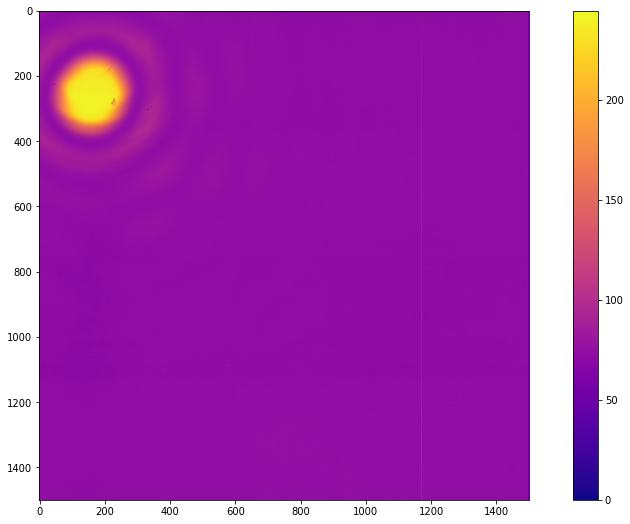

In [9]:
fig1 = plt.subplots(figsize=(16,9))
plt.imshow(np.sqrt(im),  cmap='plasma')
plt.colorbar()
plt.show()

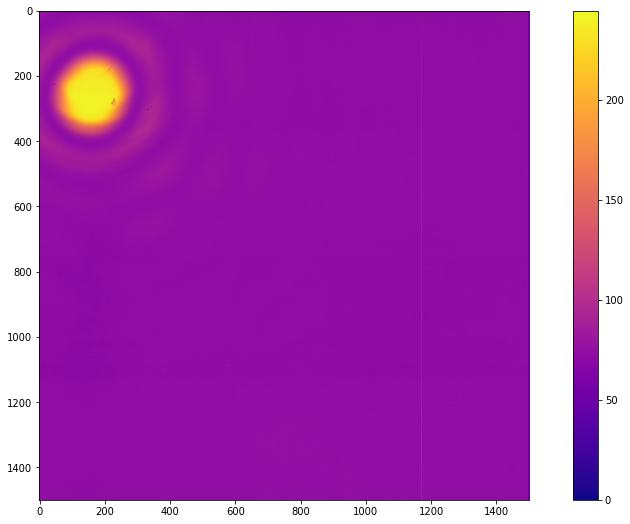

In [8]:
vv0 = np.sqrt(np.min(im))
vv1 = np.sqrt(np.max(im))
fig2 = plt.subplots(figsize=(16,9))
plt.imshow(np.sqrt(im),vmin=vv0, vmax=vv1,  cmap='plasma')
plt.colorbar()
plt.show()

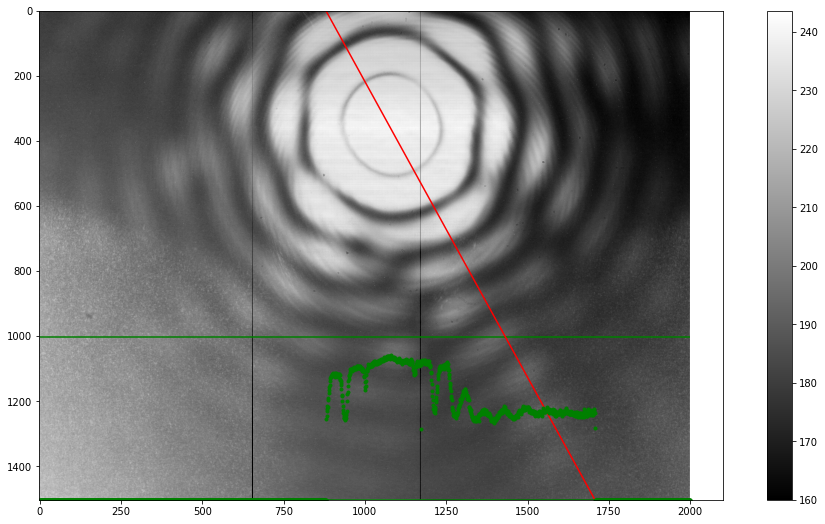

In [ ]:
# Define a line from 2 points and plot the intensity over the line

p1 = [400,1100]
p2 = [1400,1650]
mm = (p2[0] - p1[0])/(p2[1] - p1[1]) #; print(mm)
cc = p2[0] - mm*p2[1] #; print(cc)

xx= np.arange(nxx)
yy = cc+ mm*xx

ll = []
for i in xx:
    if int(yy[i])<nyy and int(yy[i]) >0:
        ll.append(im[int(yy[i]),i])
    else:
        ll.append(0)
ll = np.asarray(ll)

fig3 = plt.subplots(figsize=(16,9))
plt.imshow(np.sqrt(im),vmin=160, vmax=vv1,  cmap='gray')
plt.colorbar()
plt.plot(xx,yy, 'r')
scale = 1.0/2**16
plt.plot(xx,nyy -(ll*scale)*500, 'g.')
plt.ylim(nyy, 0)
plt.hlines(nyy, 0, nxx, color='green')
plt.hlines(nyy-500, 0, nxx, color='green')
plt.show()

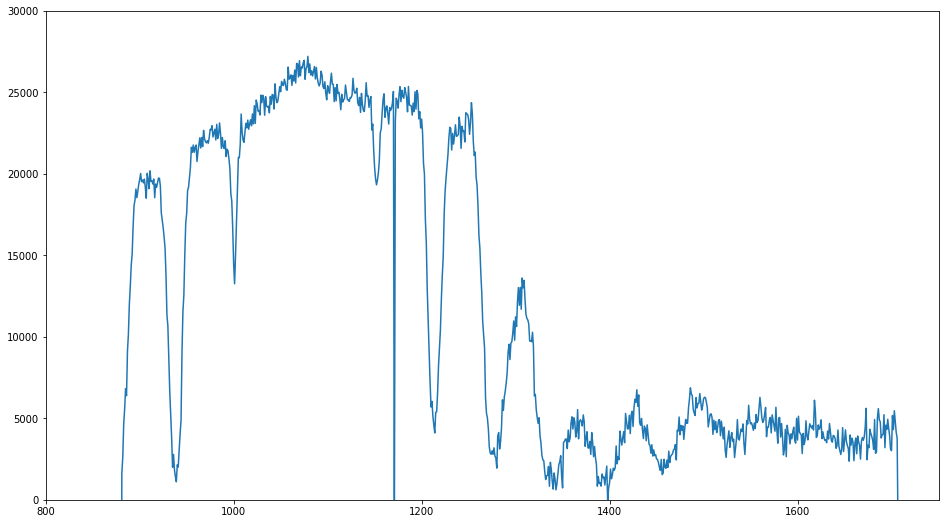

In [ ]:
fig4 = plt.subplots(figsize=(16,9))
plt.plot(ll-31000)
plt.xlim(800,1750)
plt.ylim(0,30000)
plt.show()